In [1]:
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pp
import seaborn as sns

# Input data files are available in the "../input/" directory.

import os

C:\Users\Admin\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Admin\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Admin\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\Adm

In [2]:
data = pd.read_excel("C:\\Users\\Admin\\Desktop\\machine_learning\\Sample - Superstore.xls", encoding = "unicode_escape")

# DATA PREPROCESSING 

In [3]:
furniture = data.loc[data['Category'] == 'Furniture']
office = data.loc[data['Category'] == 'Office Supplies']

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

# Data exploration

In [5]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)


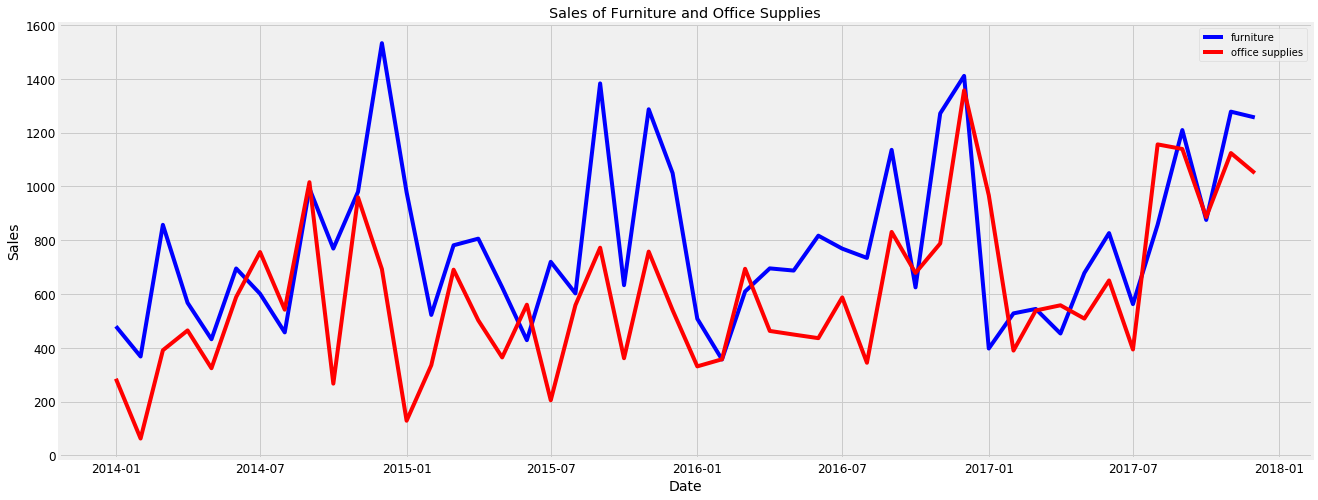

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [7]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


# Time Series Modeling with Prophet

In [8]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet()
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet()
office_model.fit(office) 




ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

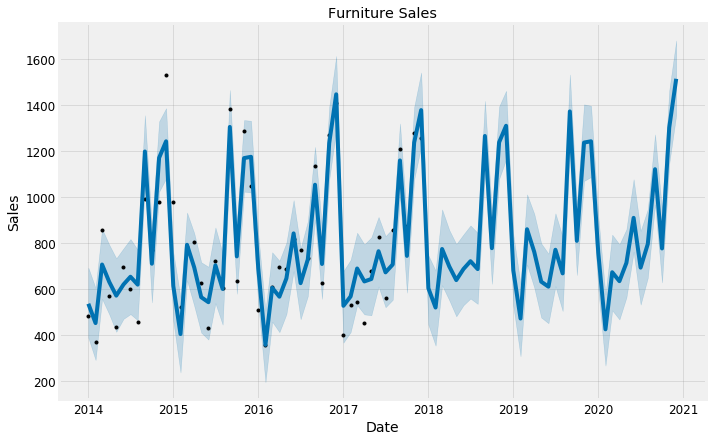

In [10]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

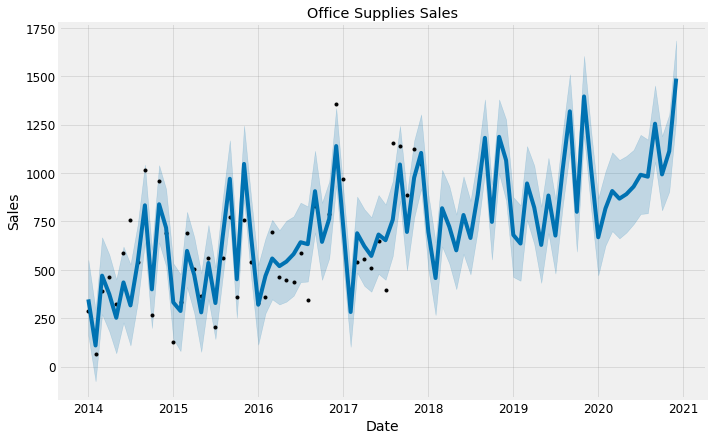

In [11]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Compare Forecasts

In [24]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

forecast.tail(24)

,Date,furniture_trend,furniture_trend_lower,furniture_trend_upper,furniture_yhat_lower,furniture_yhat_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_yhat,office_trend,office_trend_lower,office_trend_upper,office_yhat_lower,office_yhat_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_yhat
60,2019-01-01,810.660980,810.660967,810.660990,527.188476,837.767259,-130.055125,-130.055125,-130.055125,0.0,0.0,0.0,-130.055125,-130.055125,-130.055125,680.605855,923.051095,923.036559,923.064926,463.247913,875.760013,-242.383927,-242.383927,-242.383927,0.0,0.0,0.0,-242.383927,-242.383927,-242.383927,680.667168
61,2019-02-01,812.097290,812.097276,812.097301,306.686107,620.871710,-341.079140,-341.079140,-341.079140,0.0,0.0,0.0,-341.079140,-341.079140,-341.079140,471.018150,930.449482,930.433151,930.464850,443.571021,833.981774,-294.476950,-294.476950,-294.476950,0.0,0.0,0.0,-294.476950,-294.476950,-294.476950,635.972532
62,2019-03-01,813.394601,813.394586,813.394614,706.044295,1012.200309,46.620746,46.620746,46.620746,0.0,0.0,0.0,46.620746,46.620746,46.620746,860.015348,937.131895,937.113755,937.148861,758.174629,1139.352976,9.601054,9.601054,9.601054,0.0,0.0,0.0,9.601054,9.601054,9.601054,946.732949
63,2019-04-01,814.830911,814.830894,814.830925,605.887109,927.144093,-53.528569,-53.528569,-53.528569,0.0,0.0,0.0,-53.528569,-53.528569,-53.528569,761.302342,944.530282,944.510986,944.548759,632.802358,1039.027961,-122.382605,-122.382605,-122.382605,0.0,0.0,0.0,-122.382605,-122.382605,-122.382605,822.147677
64,2019-05-01,816.220888,816.220869,816.220904,475.292820,798.106886,-184.631339,-184.631339,-184.631339,0.0,0.0,0.0,-184.631339,-184.631339,-184.631339,631.589549,951.690011,951.668739,951.710408,432.803214,826.933497,-322.749419,-322.749419,-322.749419,0.0,0.0,0.0,-322.749419,-322.749419,-322.749419,628.940592
65,2019-06-01,817.657197,817.657177,817.657214,450.567975,753.666364,-207.846148,-207.846148,-207.846148,0.0,0.0,0.0,-207.846148,-207.846148,-207.846148,609.811049,959.088397,959.065531,959.110724,689.774468,1078.816856,-74.742029,-74.742029,-74.742029,0.0,0.0,0.0,-74.742029,-74.742029,-74.742029,884.346368
66,2019-07-01,819.047174,819.047152,819.047193,611.719908,929.505067,-48.294657,-48.294657,-48.294657,0.0,0.0,0.0,-48.294657,-48.294657,-48.294657,770.752517,966.248126,966.222835,966.272644,481.286986,866.356016,-289.039775,-289.039775,-289.039775,0.0,0.0,0.0,-289.039775,-289.039775,-289.039775,677.208351
67,2019-08-01,820.483484,820.483459,820.483504,503.648947,826.925221,-152.742582,-152.742582,-152.742582,0.0,0.0,0.0,-152.742582,-152.742582,-152.742582,667.740901,973.646513,973.619289,973.673005,826.891115,1208.893283,43.876319,43.876319,43.876319,0.0,0.0,0.0,43.876319,43.876319,43.876319,1017.522832
68,2019-09-01,821.919793,821.919767,821.919815,1225.953352,1534.366157,551.713042,551.713042,551.713042,0.0,0.0,0.0,551.713042,551.713042,551.713042,1373.632835,981.044899,981.015560,981.073001,1111.802502,1510.755043,338.281914,338.281914,338.281914,0.0,0.0,0.0,338.281914,338.281914,338.281914,1319.326813
69,2019-10-01,823.309770,823.309742,823.309793,660.661134,968.025780,-13.792198,-13.792198,-13.792198,0.0,0.0,0.0,-13.792198,-13.792198,-13.792198,809.517572,988.204628,988.173475,988.234956,594.489077,1009.453856,-188.232901,-188.232901,-188.232901,0.0,0.0,0.0,-188.232901,-188.232901,-188.232901,799.971727


# Visualising Trend And Forcast

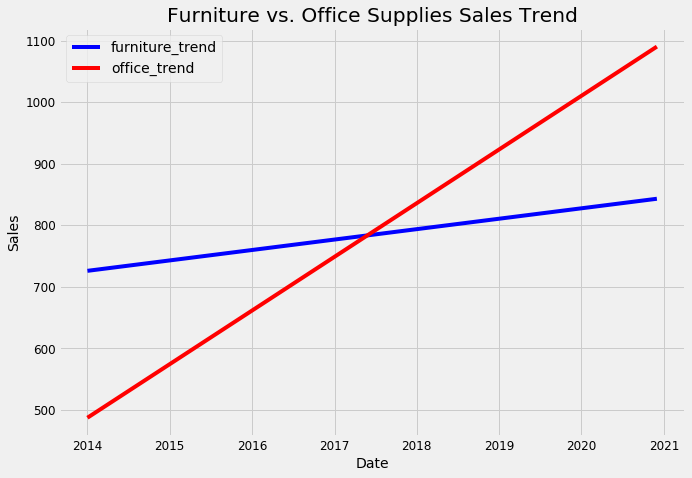

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

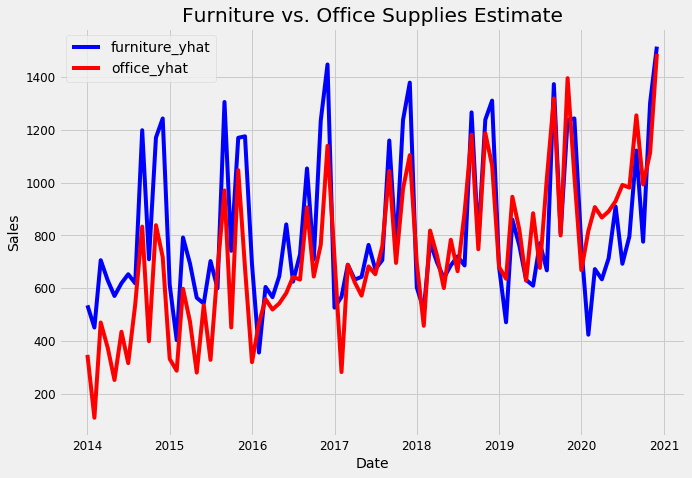

In [37]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns

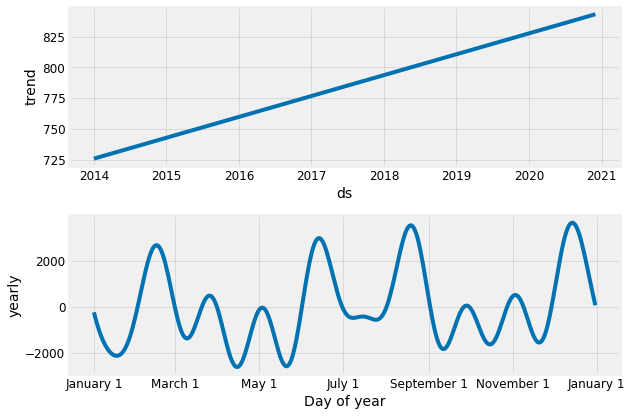

In [38]:
furniture_model.plot_components(furniture_forecast);

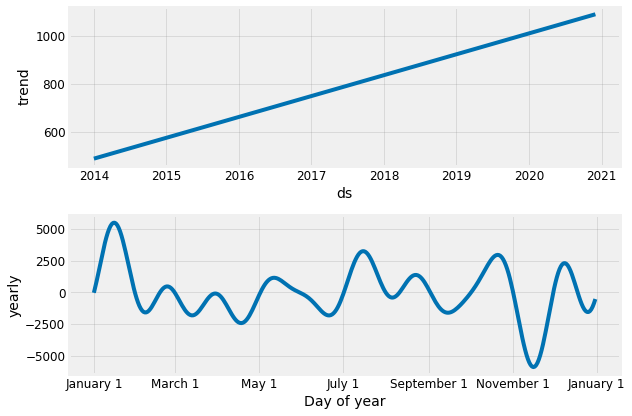

In [39]:
office_model.plot_components(office_forecast);